# Low rank and multi-task regression 

## Régression de faible rang sur des données simulées



*   Créer une matrice de rang faible $W$. Vous pouvez créer par exemple une matrice $W$ de taille $15 \times 15$ avec un rang égale à 2. Pour créer une matrice de rang faible, vous pouvez utiliser la formule $rang(AB) \leq \min(rang(A),rang(B))$. Afficher la matrice avec la commande `imshow`. 





Rang de W :  2


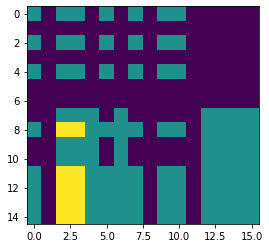

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#On utilise une graine pour rendre les résultats reproductibles mais on peut faire sans
rd = np.random.RandomState(42)
r = 2
d = 15
n_tasks = 16

W =  np.dot(rd.randint(0, 2, size=(d, r)), rd.randint(0, 2, size=(r, n_tasks)))
plt.imshow(W)
print('Rang de W : ', np.linalg.matrix_rank(W))

*   Générer des données d'apprentissage $\{(x_i,y_i), i=1,\ldots,n\}$ suivant le modèle $y_i = Wx_i + \epsilon_i$.

In [2]:
from sklearn.model_selection import train_test_split 

def generate_data(W, n_feat, n_sample=100) :
    """
    Generate a data set X, Y s.t. Y_i = W.Y_i + norm(0, 1).

    Parameters
    ----------
    W : (n_feat, n_tasks) array
        Matrix of the coefficients
    n_feat : int 
        Number of features for the model (columns of X)
    n_sample : int
        Size of the sample 

    Returns
    -------
    X : (n, d) array
        X (individualsxfeatures) array of the sample
    Y : (n, n_tasks) array
        Array of corresponding labels, for each individual(row) and task(column)
    """
    X = rd.rand(n_sample, n_feat)
    Y = np.matmul(X, W) + rd.normal(size=(n_sample, n_tasks), scale=1) 
    return X, Y

n = 100

X, Y = generate_data(W, d, n)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print('Train sample sizes : X :', X_train.shape, ' y :', Y_train.shape, 
      '\nTest sample sizes : X :', X_test.shape, 'y :', Y_test.shape)

Train sample sizes : X : (70, 15)  y : (70, 16) 
Test sample sizes : X : (30, 15) y : (30, 16)


* Implémenter la méthode de régression de faible rang. Le rang de la solution est un paramètre de la méthode.



In [3]:
def reg_ls(X, Y) :
    """
    Least square estimation of the regression coefficients.

    Parameters
    ----------
    X : (n, d) array
        X (individualsxfeatures) array of the sample
    Y : (n, n_tasks) array
        Array of corresponding labels, for each individual(row) and task(column)    
    
    Returns
    -------
    W_ls : (n_feat, n_tasks) array
        Matrix of the estimated least square regression coefficients
    """
    W_ls = np.linalg.multi_dot([np.linalg.inv(np.matmul(X.T, X)), X.T, Y])
    return W_ls

def reg_low_rank(X, Y, rank) :
    """
    """
    W_ls = reg_ls(X, Y) #LS method solution
    Y_ls = np.matmul(X, W_ls) #LS method prediction
    U, D, V = np.linalg.svd(Y_ls)
    projV = np.matmul(V[:rank, :].T, V[:rank, :])
    W_low_rank = np.matmul(W_ls, projV)
    return W_low_rank

W_ls = reg_ls(X_train, Y_train)
print('Rang de la solution moindres carrés = ', np.linalg.matrix_rank(W_ls))
W_r = reg_low_rank(X_train, Y_train, 2)
print('Taille de W_r :', W_r.shape)
print('Rang de la solution de rang faible <=2 : rg(W_r) =',np.linalg.matrix_rank(W_r))

Rang de la solution moindres carrés =  15
Taille de W_r : (15, 16)
Rang de la solution de rang faible <=2 : rg(W_r) = 2


* Evaluer les performances de prédiction de la régression de faible rang sur un jeu de données test. Comparer les résultats avec la régression par moindres carrés. 



In [4]:
train_err_ls = np.linalg.norm(
    np.dot(X_train, W_ls) - Y_train) / np.sqrt(Y_train.shape[0])
train_err_low_rank = np.linalg.norm(
    np.dot(X_train, W_r) - Y_train) / np.sqrt(Y_train.shape[0])

print('least squares method train error = ', np.round(train_err_ls, 3),
      '\nlow rank method train error = ', np.round(train_err_low_rank, 3))

pred_ls = np.dot(X_test, W_ls)
pred_low_rank = np.dot(X_test, W_r)

test_err_ls = np.linalg.norm(pred_ls - Y_test) / np.sqrt(Y_test.shape[0])
test_err_low_rank = np.linalg.norm(pred_low_rank - Y_test) / np.sqrt(Y_test.shape[0])

print('least squares method test error = ', np.round(test_err_ls, 3),
      '\nlow rank method test error = ', np.round(test_err_low_rank, 3))
#Meilleure performance en généralisation pour la méthode de rang faible 

least squares method train error =  3.518 
low rank method train error =  3.863
least squares method test error =  4.277 
low rank method test error =  4.011


La méthode de rang faible semble avoir une meilleure capacité de généralisation que la méthode des moindres carrés.

* Afficher les matrices de paramètres $W_r$ et $W_{LS}$ obtenues par les deux méthodes et comparer les résultats. Comparer les résultats en mesurant l'erreur entre la vraie matrice W utilisée pour générer les données et les matrices $W_r$ et $W_{LS}$ obtenues dans les deux stratégies d'estimation.



Erreur entre la vraie matrice et la matrice estimée (en utilisant la norme de Frobenius) 
|W_ls - W| : 6.109339167931592 
|W_r - W| :  2.008403762229326


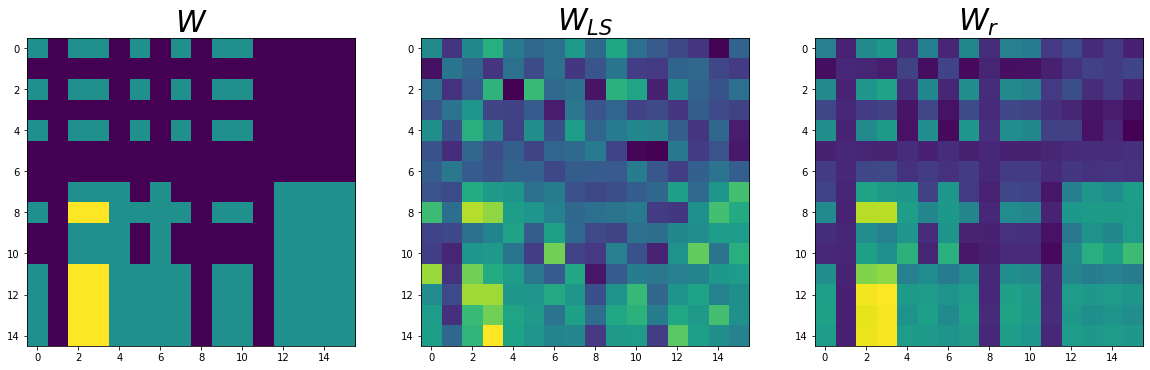

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))
ax[0].imshow(W)
ax[1].imshow(W_ls)
ax[2].imshow(W_r)
ax[0].set_title(r'$W$', fontsize=30)
ax[1].set_title(r'$W_{LS}$', fontsize=30)
ax[2].set_title(r'$W_r$', fontsize=30)
#Visuellement on voit que W_r se rapproche plus de la vraie matrice W que W_ls

#Distance en utilisant la norme de Frobenius 
print('Erreur entre la vraie matrice et la matrice estimée (en utilisant la norme de Frobenius)',
      '\n|W_ls - W| :' , np.linalg.norm((W - W_ls), ord='fro'),
      '\n|W_r - W| : ', np.linalg.norm((W - W_r), ord='fro'))
#L'erreur entre la vraie matrice W et la matrice estimée est plus petite pour W_r

L'erreur entre les matrices de coefficients etimées et la vraie matrice est plus petite pour $W_r$ que pour $W_{LS}$.

* Evaluer l'impact du choix du rang sur les résultats. Evaluer l'impact du choix du rang sur les résultats en faisant varier le rang de $W_r$ et en traçant l'erreur de test en fonction du rang de $W_r$ (le rang r de $W$ ne change pas).

Rang minimiseur = 2


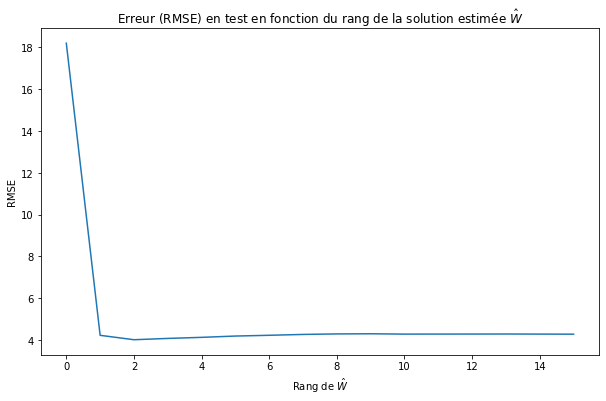

In [6]:
rank_values = np.arange(16)
W_rank_values = []
test_err_low_rank_values = []

for rank in rank_values :
    W_rank = reg_low_rank(X_train, Y_train, rank)
    W_rank_values.append(np.linalg.matrix_rank(W_rank))
    test_err_low_rank_values.append(np.linalg.norm(
        np.dot(X_test, W_rank) - Y_test) / np.sqrt(Y_test.shape[0]))

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(W_rank_values, test_err_low_rank_values)
ax.set(xlabel=r'Rang de $\hat W$', ylabel='RMSE', 
          title=r'Erreur (RMSE) en test en fonction du rang de la solution estimée $\hat W$')

print('Rang minimiseur =', W_rank_values[np.argmin(test_err_low_rank_values)])
#L'erreur décroit avec l'augmentation du rang.
#Après le rang 2, elle se stabilise (mais remonte légèrement) 
#Le rang qui minimise l'erreur de test est = 2 (= rang de la vraie matrice W)

L'erreur décroit avec l'augmentation du rang.
Après le rang 2, elle se stabilise (en remomtant légèrement). 
Le rang qui minimise l'erreur de test est = 2 (= rang de la vraie matrice W).

## Apprentissage multi-tâche et régularisation



*   Télécharger un jeu de données d'apprentissage multi-tâche (vous pouvez utiliser un jeu de données de régression multivariée par exemple : "Canadian Weather Data Set" (https://fda.readthedocs.io/en/latest/modules/autosummary/skfda.datasets.fetch_weather.html?highlight=weather%20data#skfda.datasets.fetch_weather) où l'objectif est de prédire des courbes de précipitation à partir des courbes de température). 

*   La régression multitaskLasso est déjà implémenté dans le module `linear_model` de scikit-learn. Expliquer le fonctionnement de cette méthode.


*   Comparer les méthodes de régression ridge, régression Lasso, régression de rang faible et régression multitaskLasso.



Soient $X \in \mathbb{R}^{n \times d}$, $Y \in \mathbb{R}^n$.

Le problème LASSO se formalise ainsi :

$$\mathrm{argmin}_{W \in \mathbb{R}^d} || Y - XW ||^2_2 +  \lambda ||w||_1 $$

avec $\lambda > 0$ une constante à fixer. 

IL s'agit d'un problème de régression des moindres carrés auquel on a ajouté une pénalisation. Le terme $ \lambda ||w||_1 $ est le terme de pénalisation, qui permet d'introduire de la sparsité dans les coefficients du vecteur de paramètres $W$ grâce à la contrainte sur la norme $||.||_1$.  

On considère un échantillon $S := \left(x_i, y_i\right)_{i=1} ^n$ avec $x_i \in \mathbb{R^d}$. Dans le problème de régression linéaire classique $y_i$ est une étiquette réelle, $y_i \in \mathbb{R}$. Dans un problème de régression multi-tâche, on ne désire plus prédire une étiquette réelle $y_i \in \mathbb{R}$ par donnée d'entrée $x_i$ mais plusieurs, correspondant à plusieurs tâches, avec de possibles liens entre elles, que l'on souhaiterait alors exploiter. On considère alors un vecteur, avec autant de colonnes que de tâches : $y_i \in \mathbb{R^{d \times p}}$, avec $p$ le nombre de tâches. 

Dans le cas multi-tâche, le problème LASSO devient :

$$ \mathrm{argmin}_{W \in \mathbb{R}^{d \times p}}  ||Y - XW||^2_F + \lambda ||W||_{21}$$

avec $||A||_{\text{F}} = \sqrt{\sum_{ij} a_{ij}^2}$ la norme de Frobenius et $||A||_{2 1} = \sum_i \sqrt{\sum_j a_{ij}^2}$.


Il introduit de la sparsité sur les lignes de la matrice des coefficients $W$.

Dans le package scikit-learn, la classe MultiTaskLasso utilise la "descente de coordonnées" (coordinate descent) pour estimer les paramètres $W$ à partir des exemples d'apprentissage.

In [7]:
! pip -q install scikit-fda

In [8]:
from skfda.datasets import fetch_weather
from skfda.representation.basis import Fourier, FDataBasis

#Dataset : daily temperature and precipitation at 35 different locations in Canada averaged over 1960 to 1994
weather = fetch_weather()
fd = weather['data']
# Split dataset, temperatures and curves of precipitation
X, y = fd.coordinates

 /usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning:The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.


[Text(0.5, 1.0, 'Smoothed precipitation curves')]

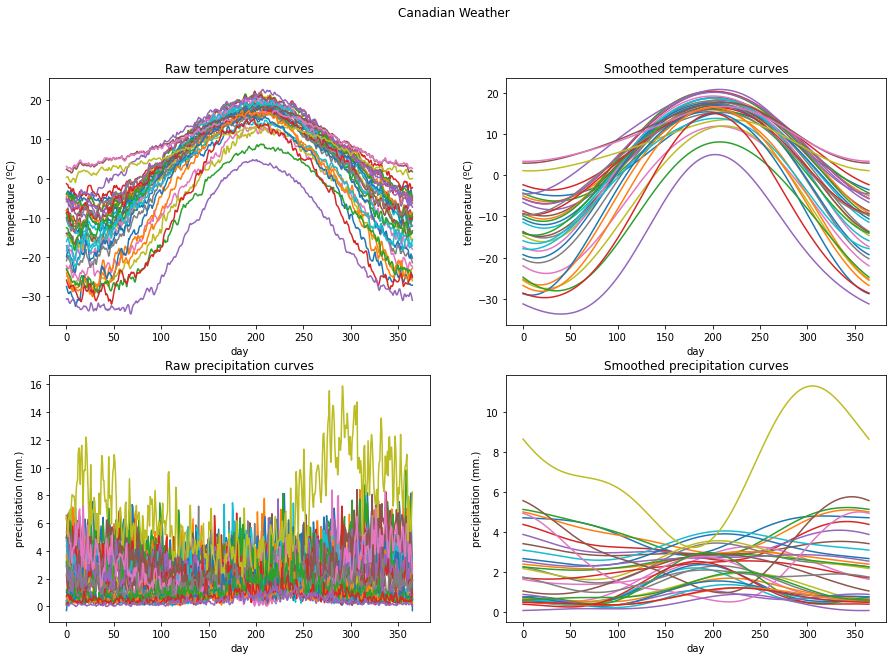

In [9]:
#Plot des courbes de température
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
X.plot(ax[0, 0])
X = X.to_basis(Fourier(n_basis=5))
X.plot(ax[0, 1])
ax[0, 0].set(title='Raw temperature curves')
ax[0, 1].set(title='Smoothed temperature curves')
y.plot(ax[1, 0])
y = y.to_basis(Fourier(n_basis=5))
y.plot(ax[1, 1])
ax[1, 0].set(title='Raw precipitation curves')
ax[1, 1].set(title='Smoothed precipitation curves')


On veut estimer les paramètres d'une fonction de régression qui nous permette de prédire les courbes de précipitation sur l'année à partir des courbes de température sur cette année. Nous avons lissé les données et nous disposons, pour chaque courbe, de 5 coefficients dans une base Fourier, qui modélisent la courbe. Nous allons donc considérer comme données :

* $x_i$ vecteur de taille 5 correspondant à la $i$-ième courbe de température  
* $y_i$ vecteur de taille 5 correspondant à la $i$-ème courbe de précipitation 

pour $i = 1, \cdots, n=35$. Chaque "individu" $i$ correspond à un site de prélèvement des données au Canada.

Ensuite nous utiliserons les vecteurs de coefficients $y_i$ générés (qui sont dans une base de Fourier) pour "récupérer" les courbes correspondantes. 

Nous allons comparer les performances de prédiction des différentes méthodes de régression (Ridge, Lasso, Rang faible, MultiTaskLasso) en ayant au préalable sélectionné les paramètres optimaux par cross-validation.

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import Ridge, Lasso, MultiTaskLasso
from sklearn.model_selection import GridSearchCV

#Nous devons implémenter une méthode pour la régression de faible rang
class LowRankRegression():
    """ 
    Class implementing the low rank regression.

    Parameters
    ----------
    rank : int
        Desired rank of the matrix of constrained estimated regresion coefficients

    Attributes
    ----------
    X_ : (n, n_features) array
        X array of the sample
    y_ : (n, n_tasks) array
        Array of the vector valued labels (multiple tasks) related to X_
    weights_ : (n_features, n_tasks) array
        Matrix of the constrained estimated regression coefficients
    """
    def __init__(self, rank=2):
        self.rank = rank

    def fit(self, X, y):
        self.X_ = X
        self.y_ = y
        self.weights_ = reg_low_rank(X, y, int(self.rank))
        return self

    def predict(self, X):
        return np.dot(X, self.weights_)

    def get_params(self, deep=True):
          return {'rank': self.rank}

    def set_params(self, **parameters):
          for parameter, value in parameters.items():
            setattr(self, parameter, value)
          return self

In [11]:
methods = [Ridge(), Lasso(), LowRankRegression(), MultiTaskLasso()]

ridge_params = {'alpha' : [0.001, 0.01, 0.1, 1, 2, 3]}
lasso_params = {'alpha' : [0.001, 0.01, 0.1, 1, 2, 3], 'selection' : ['cyclic', 'random']}
low_rank_params = {'rank' : [1, 2, 3, 4, 5]}
multi_lasso_params = {'alpha' : [0.001, 0.01, 0.1, 1, 2, 3], 'selection' : ['cyclic', 'random']}
param_grid = [ridge_params, lasso_params, low_rank_params, multi_lasso_params]

best_params = []
best_scores = []
best_model = []

#Peprocess dataset, split into training and test part 
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X, y, test_size=0.3, random_state=10)
X_train, X_test = X_train_data.coefficients, X_test_data.coefficients
y_train, y_test = y_train_data.coefficients, y_test_data.coefficients
print('Train set size =', len(y_train), '\nTest set size =', len(y_test))

#Cross-validation to tune the hyperparameters of each method
#We perform the cross-validation on the training set
for reg, params in zip(methods, param_grid):
    #we use a leave-one-out cross-validation since we have very few examples
    #k-fold with k=n_train
    gCV = GridSearchCV(reg, param_grid = params, cv=len(y_train), 
                       scoring='neg_mean_squared_error', n_jobs=-1,
                       refit=True)
    gCV.fit(X_train, y_train)
    best_scores.append(gCV.best_score_)
    best_params.append(gCV.best_params_)
    best_model.append(gCV.best_estimator_)

Train set size = 24 
Test set size = 11


In [12]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
names = ['Ridge', 'Lasso', 'LowRank', 'MultiTaskLasso']
scores_df = pd.DataFrame({'regression method' : names, 
                          'best parameters' : best_params[:len(names)],
                          '-mse' : best_scores[:len(names)]})
scores_df

,regression method,best parameters,-mse
0,Ridge,{'alpha': 3},-134.243
1,Lasso,"{'alpha': 3, 'selection': 'random'}",-127.231
2,LowRank,{'rank': 5},-147.753
3,MultiTaskLasso,"{'alpha': 3, 'selection': 'random'}",-128.334


A cette étape, la méthode qui a la plus faible erreur de test à hyperparamètre "optimal" fixé est la régression Lasso de paramètres $\alpha = 3$ et avec une sélection 'random'. Ensuite vient la méthode MultiTaskLasso ($\alpha = 3$ et selection 'random'). Puis la régression Ridge ($\alpha=3$). La méthode de rang faible donne les plus mauvais résultats.

Nous allons utiliser ces modèles, entraînés avec les paramètres déterminés grace à l'option refit=True, pour évaluer les performances sur les exemples de test mis de côté.

Ridge test RMSE = 23.631712982695547
Lasso test RMSE = 23.84662682293883
LowRank test RMSE = 27.43199938170214
MultiTaskLasso test RMSE = 23.786015928658475


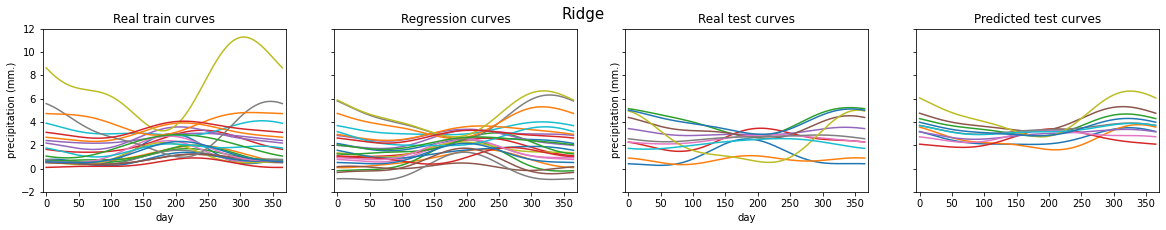

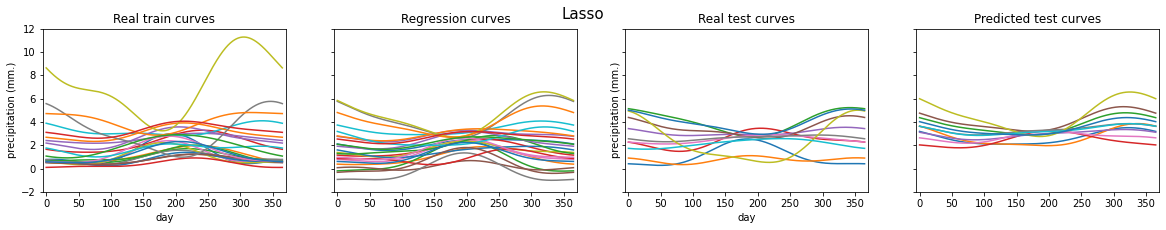

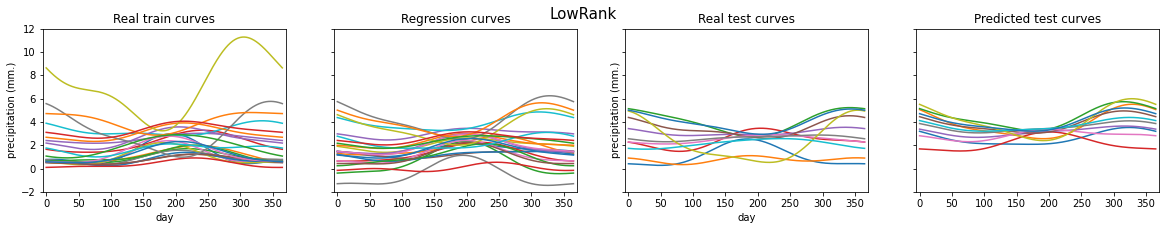

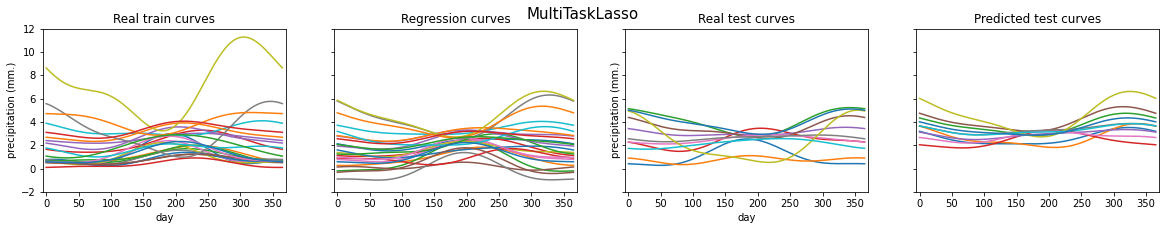

In [13]:
i = 0
for fitted_model, method in zip(best_model, names) :
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 3), sharex=True, sharey=True)
    for a in ax.flatten() :
      a.set_xlim([-5, 370])
      a.set_ylim([-2, 12])
    pred = fitted_model.predict(X_test)
    print(method + ' test RMSE =', 
          np.linalg.norm(pred - y_test) / np.sqrt(y_test.shape[0]))

    #Visualisation de la regression sur données train
    reg_curves = FDataBasis(basis=y.basis, coefficients=fitted_model.predict(X_train))
    y_train_data.plot(ax[0])
    reg_curves.plot(ax[1])
    ax[0].set(title='Real train curves')
    ax[1].set(title='Regression curves')

    #Visualisation de la régression sur les données test
    pred_curves = FDataBasis(basis=y.basis, coefficients=pred)
    y_test_data.plot(ax[2])
    pred_curves.plot(ax[3])
    ax[2].set(title='Real test curves')
    ax[3].set(title='Predicted test curves')

    fig.suptitle(method + '\n\n', size=15)


    i+=1

La méthode de régression Ridge donne la plus petite erreur (RMSE) en test. Elle est suivie de très près par la régression MultiTaskLasso et Lasso. 

La méthod de faible rang a la plus grande erreur de test, mais qui reste relativement proche des performances des autres méthodes. Globalement les prédictions des 4 méthodes et leurs performances sont assez similaires.